## PIMS Hackathon, Seattle 2025
### Project B - Preconditioners for Thermal Radiative Transfer
Packages: jupyter, numpy, matplotlib

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from library import *
from post_process import *

L2  : 8.762331740438677e-10
Linf: 4.312269652473333e-09


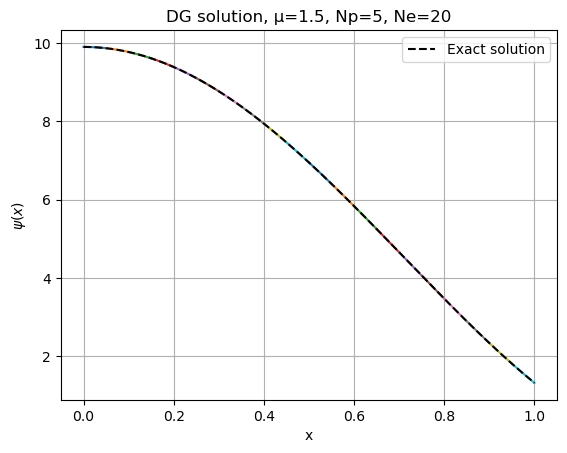

In [2]:
# ─── Example usage ───

# Parameters for the transport problem
μ       = 1.5
σ_t     = lambda x: x**2 + 1
source  = lambda x: (μ**3)*(2*x - 6.8*np.sin(2*x)) + (σ_t(x) * (μ**2)*((x**2 +1) + 3.4*np.cos(2*x)))
inflow  = lambda x: (μ**2)*((x**2 +1) + 3.4*np.cos(2*x))

# Mesh parameters
Ne = 20
xs      = np.linspace(0, 1, Ne + 1) # Mesh points / element boundaries
Np      = 5                     # Legendre polynomials per element (basis size)

# Plot numerical solution against the exact solution (MMS)
ψ_MMS     = lambda x: (μ**2)*((x**2 +1) + 3.4*np.cos(2*x))
ψ_weights = transport_direct_solve(μ, σ_t, compute_source_term(source, Np, xs), inflow, Np, xs)
ψ_weights = ψ_weights.reshape(Ne, Np)

# Print the error in the solution
print("L2  :",error_Lp(ψ_weights, xs, Np, ψ_MMS, p=2))
print("Linf:",error_Lp(ψ_weights, xs, Np, ψ_MMS, p='inf'))
plot_solution(ψ_weights, xs, Np, μ=μ, exact_ψ_func=ψ_MMS)

100%|██████████| 15/15 [00:20<00:00,  1.34s/it]

Chosen μ: -0.6546536707079773
L2  : 7.771886982298686e-11
Linf: 3.0163949116257527e-10


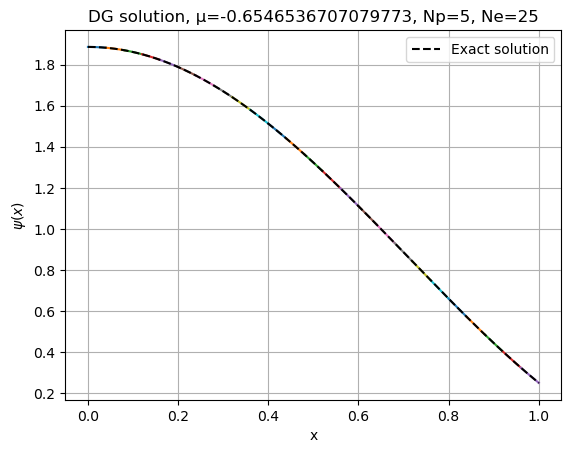

In [3]:
# ─── Example usage (Fixed point iteration) ───

# Parameters for the transport problem
ψ_MMS  = lambda x,μ: (μ**2)*((x**2 +1) + 3.4*np.cos(2*x)) # Manufactured solution
σ_t    = lambda x: x**3 + 1
σ_a    = lambda x: x**2 + 1
ε      = 1.1
source = lambda x,μ: (μ**3)/ε * (2*x - 6.8*np.sin(2*x)) + (σ_t(x)/ε**2 * ψ_MMS(x,μ)) \
                   - (σ_t(x)/ε - ε*σ_a(x)) / (3*ε) * ψ_MMS(x,μ) / (μ**2)
inflow = lambda x,μ: ψ_MMS(x,μ)
 
# Mesh parameters
Np = 5                      # Legendre polynomials per element (basis size)
Nμ = 5                      # Legendre polynomials per element (basis size)
Nt = 15                      # Legendre polynomials per element (basis size)
xs = np.linspace(0, 1, 26) # Mesh points / element boundaries

# Solve
ψ_weights_all, μs = transport_direct_solve_diffusive(σ_t, σ_a, ε, source, inflow, Np, Nμ, Nt, xs)
μi = 1 # Chosen μ for the error calculation
μc = μs[μi]
print("Chosen μ:", μc)

# Print the error in the solution
print("L2  :",error_Lp(ψ_weights_all[μi,:,:], xs, Np, lambda x: ψ_MMS(x,μc), p=2))
print("Linf:",error_Lp(ψ_weights_all[μi,:,:], xs, Np, lambda x: ψ_MMS(x,μc), p='inf'))

# Plot numerical solution against the exact solution (MMS)
plot_solution(ψ_weights_all[μi,:,:], xs, Np, μ=μc, exact_ψ_func=lambda x: ψ_MMS(x,μc))